# Multi-Class Tabular Model for Avila Bible Identification Using Python and Scikit-Learn
### David Lowe
### May 16, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Avila Bible Identification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The Avila dataset includes 800 images extracted from the "Avila Bible," a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain. The paleographic analysis of the manuscript has identified the presence of 12 transcribers; however, each transcriber did not transcribe the same number of pages. The prediction task is to associate each pattern to one of the 12 transcribers labeled as A, B, C, D, E, F, G, H, I, W, X, and Y. The research team normalized the data using the Z-normalization method and divided the dataset into two portions, training and test. The training set contains 10,430 samples, while the test set contains 10,437 samples.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 85.51% using the training dataset. Furthermore, we selected Bagging Classifier as the final model as it processed the training dataset with a final accuracy score of 98.53%. When we processed the test dataset with the final model, the model achieved an accuracy score of 99.20%.

CONCLUSION: In this iteration, the Bagging Classifier model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Avila Bible Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/avila

One source of potential performance benchmarks: https://www.sciencedirect.com/science/article/abs/pii/S0952197618300721

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'avila-tr.txt'
TEST_DATASET = 'avila-ts.txt'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-avila-bible-identification/avila-tr.txt

In [8]:
colNames = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','Class']
df_dataset_import = pd.read_csv(TRAIN_DATASET, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

         F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10 Class  
0  0.929823  0.251173  0.159345     A  
1  0.636203  0.282354  0.515587     A  
2 -0.888236 -0.123005  0.582939     A  
3  1.051693  0.594169 -0.533994     A  
4  0.051062  0.032902 -0.086652     F  


In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      10430 non-null  float64
 1   F2      10430 non-null  float64
 2   F3      10430 non-null  float64
 3   F4      10430 non-null  float64
 4   F5      10430 non-null  float64
 5   F6      10430 non-null  float64
 6   F7      10430 non-null  float64
 7   F8      10430 non-null  float64
 8   F9      10430 non-null  float64
 9   F10     10430 non-null  float64
 10  Class   10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 896.5+ KB


In [10]:
print(df_dataset_import.describe())

                 F1            F2            F3            F4            F5  \
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000   
mean       0.000852      0.033611     -0.000525     -0.002387      0.006370   
std        0.991431      3.920868      1.120202      1.008527      0.992053   
min       -3.498799     -2.426761     -3.210528     -5.440122     -4.922215   
25%       -0.128929     -0.259834      0.064919     -0.528002      0.172340   
50%        0.043885     -0.055704      0.217845      0.095763      0.261718   
75%        0.204355      0.203385      0.352988      0.658210      0.261718   
max       11.819916    386.000000     50.000000      3.987152      1.066121   

                 F6            F7            F8            F9           F10  
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000  
mean       0.013973      0.005605      0.010323      0.012914      0.000818  
std        1.126245      1.313754      1.003507      1

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

F1       0
F2       0
F3       0
F4       0
F5       0
F6       0
F7       0
F8       0
F9       0
F10      0
Class    0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
A    4286
B       5
C     103
D     352
E    1095
F    1961
G     446
H     519
I     831
W      44
X     522
Y     266
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10 target  
0  0.929823  0.251173  0.159345      A  
1  0.636203  0.282354  0.515587      A  
2 -0.888236 -0.123005  0.582939      A  
3  1.051693  0.594169 -0.533994      A  
4  0.051062  0.032902 -0.086652      F  


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      10430 non-null  float64
 1   F2      10430 non-null  float64
 2   F3      10430 non-null  float64
 3   F4      10430 non-null  float64
 4   F5      10430 non-null  float64
 5   F6      10430 non-null  float64
 6   F7      10430 non-null  float64
 7   F8      10430 non-null  float64
 8   F9      10430 non-null  float64
 9   F10     10430 non-null  float64
 10  target  10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 896.5+ KB


In [15]:
print(df_dataset_import.describe())

                 F1            F2            F3            F4            F5  \
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000   
mean       0.000852      0.033611     -0.000525     -0.002387      0.006370   
std        0.991431      3.920868      1.120202      1.008527      0.992053   
min       -3.498799     -2.426761     -3.210528     -5.440122     -4.922215   
25%       -0.128929     -0.259834      0.064919     -0.528002      0.172340   
50%        0.043885     -0.055704      0.217845      0.095763      0.261718   
75%        0.204355      0.203385      0.352988      0.658210      0.261718   
max       11.819916    386.000000     50.000000      3.987152      1.066121   

                 F6            F7            F8            F9           F10  
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000  
mean       0.013973      0.005605      0.010323      0.012914      0.000818  
std        1.126245      1.313754      1.003507      1

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

F1        0
F2        0
F3        0
F4        0
F5        0
F6        0
F7        0
F8        0
F9        0
F10       0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
A    4286
B       5
C     103
D     352
E    1095
F    1961
G     446
H     519
I     831
W      44
X     522
Y     266
dtype: int64


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets
df_target_train = df_dataset_import[CLASS_COLUMN]
df_features_train = df_dataset_import.drop([CLASS_COLUMN], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (10430, 11) df_features_train.shape: (10430, 10) df_target_train.shape: (10430,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

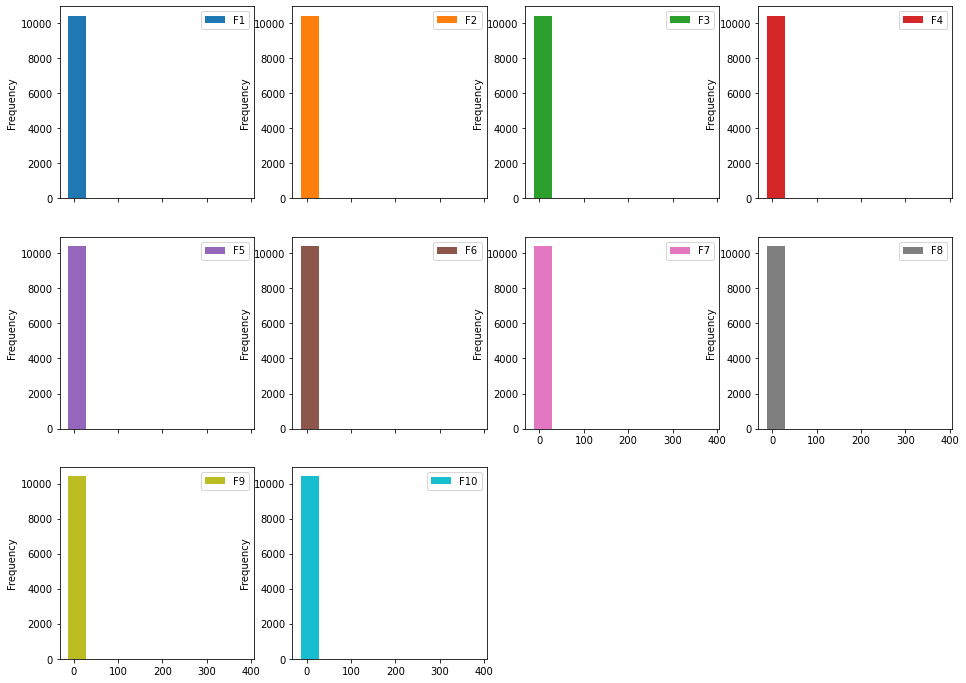

In [22]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

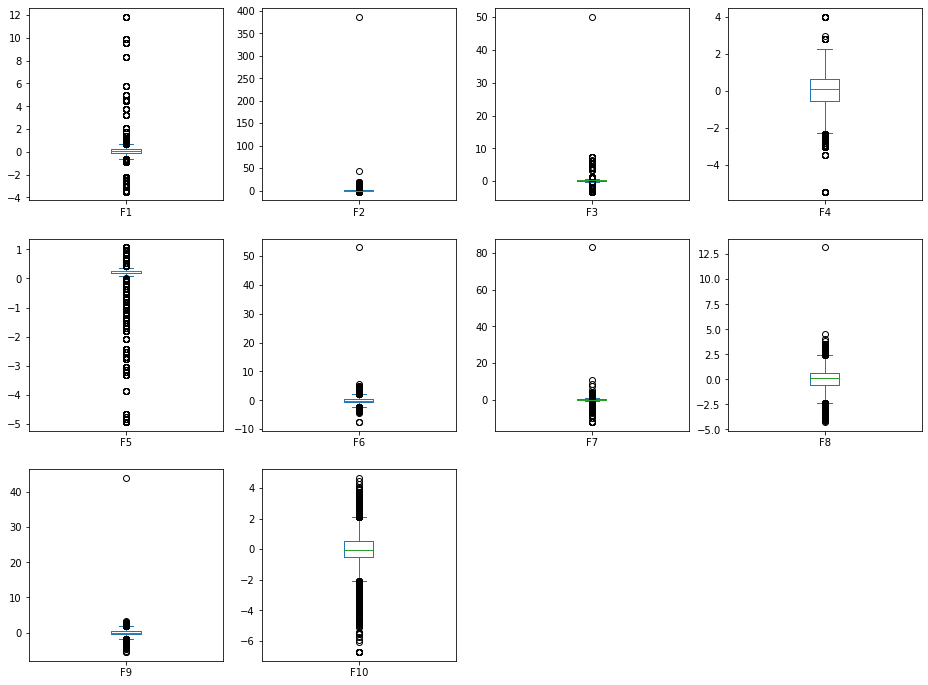

In [23]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

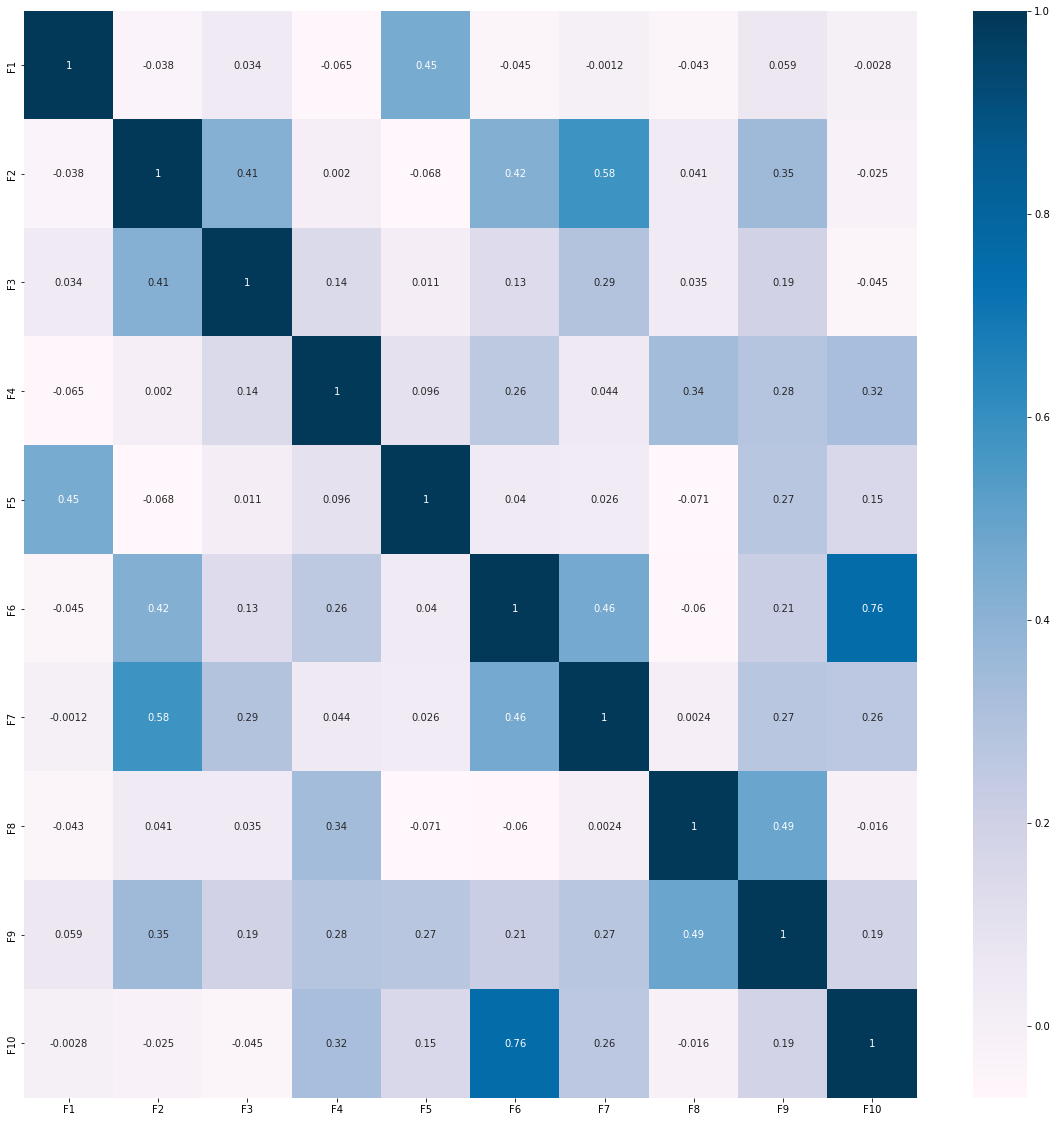

In [24]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [27]:
# Not applicable for this iteration of the project

### 3.b) Training Data Balancing

In [28]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [29]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [30]:
# Finalize the training dataset for the modeling activities
array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (10430, 10) array_target_train.shape: (10430,)


In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [32]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [33]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [34]:
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [35]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LDA: 0.505177 (0.006370)
LinearDiscriminantAnalysis()
Model training time: 0:00:00.311508 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.967306 (0.002414)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.673284 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.720518 (0.010672)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:02.713855 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.980345 (0.002626)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:05.274207 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.979674 (0.001235)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:13.284960 

EXT: 0.977948 (0.004658)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:04.632703 

Average metrics (accuracy) from all models: 0.8551613934164269
Total training time for all models: 0:00:26.943650


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


### 4.b) Spot-checking baseline algorithms

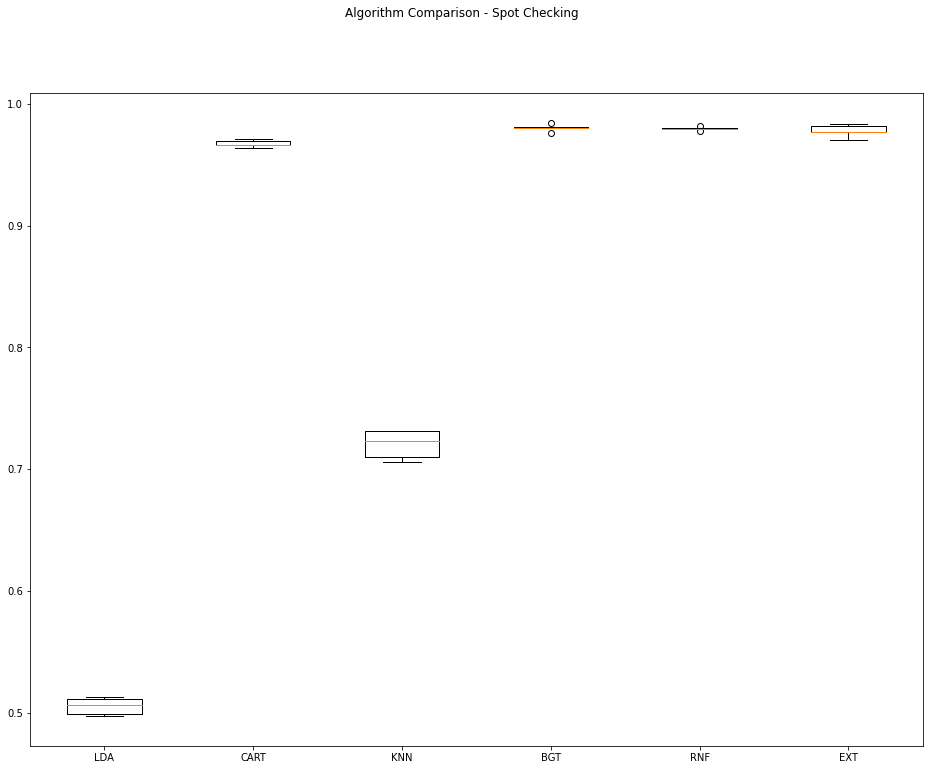

In [36]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [38]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [39]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('BGT')
paramGrid1 = dict(n_estimators=np.array([10, 30, 50]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.985331 using {'n_estimators': 50}
0.980345 (0.002626) with: {'n_estimators': 10}
0.985235 (0.001528) with: {'n_estimators': 30}
0.985331 (0.001956) with: {'n_estimators': 50}
Model training time: 0:00:22.877407


In [40]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 50


In [41]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.981783 using {'n_estimators': 500}
0.979674 (0.001235) with: {'n_estimators': 100}
0.981304 (0.002207) with: {'n_estimators': 300}
0.981783 (0.002079) with: {'n_estimators': 500}
Model training time: 0:01:31.756422


In [42]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 4.d) Compare Algorithms After Tuning

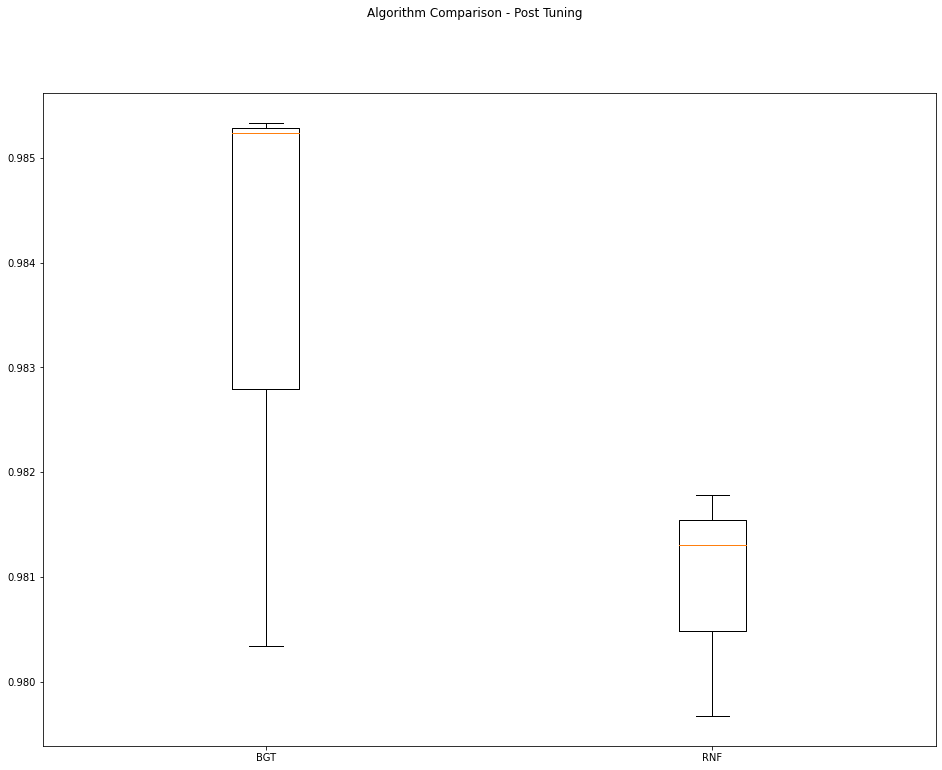

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [46]:
final_model = BaggingClassifier(n_estimators=best_paramValue1, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

BaggingClassifier(n_estimators=50, n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [47]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-avila-bible-identification/avila-ts.txt

In [48]:
df_dataset_test = pd.read_csv(TEST_DATASET, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_test.head())

         F1        F2        F3        F4        F5        F6        F7  \
0 -3.498799  0.250492  0.232070  1.224178 -4.922215  1.145386  0.182426   
1  0.204355 -0.354049  0.320980  0.410166 -0.989576 -2.218127  0.220177   
2  0.759828 -1.304042 -0.023991 -0.973663 -0.006417 -0.349509 -0.421580   
3 -0.005490  0.360409  0.281860 -0.213479 -1.168333 -1.013906 -0.346080   
4  0.080916  0.101320  0.104040  0.140490  0.261718  0.480988  0.710932   

         F8        F9       F10 Class  
0 -0.165983 -0.123005  1.087144     W  
1  0.181844  2.090879 -2.009758     A  
2 -0.450127  0.469443  0.060952     I  
3  1.176165  0.968347 -0.627999     E  
4 -0.253430 -0.497183  0.155681     A  


In [49]:
# Standardize the class column to the name of targetVar if required
df_dataset_test = df_dataset_test.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_test.head())

         F1        F2        F3        F4        F5        F6        F7  \
0 -3.498799  0.250492  0.232070  1.224178 -4.922215  1.145386  0.182426   
1  0.204355 -0.354049  0.320980  0.410166 -0.989576 -2.218127  0.220177   
2  0.759828 -1.304042 -0.023991 -0.973663 -0.006417 -0.349509 -0.421580   
3 -0.005490  0.360409  0.281860 -0.213479 -1.168333 -1.013906 -0.346080   
4  0.080916  0.101320  0.104040  0.140490  0.261718  0.480988  0.710932   

         F8        F9       F10 target  
0 -0.165983 -0.123005  1.087144      W  
1  0.181844  2.090879 -2.009758      A  
2 -0.450127  0.469443  0.060952      I  
3  1.176165  0.968347 -0.627999      E  
4 -0.253430 -0.497183  0.155681      A  


In [50]:
# We create attribute-only and target-only datasets
df_target_test = df_dataset_test[CLASS_COLUMN]
df_features_test = df_dataset_test.drop([CLASS_COLUMN], axis=1)

print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_test.shape: (10437, 10) df_target_test.shape: (10437,)


In [51]:
# Finalize the test dataset for the testing activities
array_features_test = df_features_test.to_numpy()
array_target_test = label_encoder.transform(df_target_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (10437, 10) to array_features_test.shape: (10437, 10)


In [52]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[9 0 0 ... 0 5 7]


In [53]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions),'\n')
print(confusion_matrix(array_target_test, test_predictions),'\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.992047523234646 

[[4278    0    0    0    7    0    0    1    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0    0]
 [   0    0  103    0    0    0    0    0    0    0    0    0]
 [   0    0    0  343   10    0    0    0    0    0    0    0]
 [   4    0    0    6 1081    1    0    0    0    0    3    0]
 [   5    0    0    2    0 1952    3    0    0    0    0    0]
 [   0    0    0    0    2    0  445    0    0    0    0    0]
 [   0    0    3    0    0    0    0  517    0    0    0    0]
 [   8    0    0    0    0    0    0    0  824    0    0    0]
 [   0    0    0    0    0    0    0    0    0   45    0    0]
 [   2    0    0    1   14    0    0    0    0    0  502    3]
 [   0    0    0    0    0    0    0    0    0    0    8  259]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4286
           1       1.00      1.00      1.00         5
           2       0.97      1.00      0.9

In [54]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [55]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:02:34.139386
